In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'skin-cancer-mnist-ham10000:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F54339%2F104884%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T211913Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D53226a709f88c1404941a78880d0042b0f89841d446fa36c8018d8a3ba0266ec4a1f16079f80e5bf270c7d184fcb9b97f457b04bafe4331f6417e78394cb0f6a2367dff51f58c52bd4315f4712f4f9af056d56c9c6f6c87b37008b87b53736731e639ae5e0b7e4f8eb56ba310474ada07366948cfa582833630a9968812b761d624b8802ee2108e0384ce6d8c6665f38f4a2498216b8686f6eaa024cb01ff478a2f52a422dfc7c8ae9471ebeedbe793f35a8e39746f2ac990d835f5234847a67f45919e7187c30f99123fc0f7a546d7d685d18b7c57da15fdfad0fdff03fd1b937c2679011ce2e233dc3a3e50a5deb8691a75b4d88f3d095f505f2c08d549f07'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[====                                              ] 475463680 bytes downloaded

KeyboardInterrupt: 



## <center style="background-color:Gainsboro; width:40%;">Contents</center>
1. [Overview](#1.-Overview)<br>
1.1. [Content](#1.1.-Content)<br>
2. [The Data](#2.-The-Data)<br>
2.1 [Melanoma-Malignant Cancer Analysis](#2.-Melanoma-Malignant-Cancer-Analysis)<br>

# **1. Overview**

Dermatoscopy is a diagnostic technique that can improve the diagnosis of benign and malignant pigmented skin lesions. Other than increasing the accuracy of skin cancer detection (if compared to naked eye exams), dermatoscopic images can also be used to train ANN. In the past, promising attempts have been made to use ANN to classify skin lesions. However, the lack of data and computing power limited the application of this method.

The [ISIC archive](https://isic-archive.com/) is the largest public database for dermatoscopic image analysis research, and where the original HAM10000 was made available. In 2018, the database contained approximately 13.000 dermatoscopic images. Currently, the database holds over 60.000 images, demonstrating the power of collaboration between different scientific groups.

As mentioned by the authors, the original paper and release of HAM10000 aimed to boost the research on the automated diagnosis of dermatoscopic images. We can say they have certainly achieved that goal after three successful challenges and an impressive expansion of the database.


## 1.1. Content ##

The HAM10000 dataset is composed of 10.015 dermatoscopic images of pigmented skin lesions. The data was collected from Australian and Austrian patients. Two institutions participated in providing the images: Cliff Rosendahl in Queensland, Australia, and Medical University of Vienna, Austria. According to the authors, seven classes are defined on this dataset where some diagnosis were unified into one class for simplicity. Information regarding patient age, sex, lesion location and diagnosis is also provided with each image.

In [ ]:
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(123)

# 2. The Data

In this section, we analyse our metadata and understand a bit more regarding the patients and dataset distribution.

## Key Insights

* Small number of Missing Values, only for Age features where replacement with most frequent value was used
* Similar distribution between Males and Females
* Melanocytic nevi is the dominant class in the dataset (67%). It could result in a bias towards this type of os skin lesion
* Most samples are from patients within 35 - 60 yrs old
* Melanoma, malignant skin lesion, seems to be more common in the ages of 45 to 70. Males represent 62% of the incidence of this type of lesion

A sample of each type of skin lesion present in the dataset is demonstrated in the chart below.

In [ ]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    return summary

def countplot(df, x, x_axis_title,y_axys_title, plot_title):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data = df,x=x,order = df[x].value_counts().index,palette="Blues_d")
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=0,fontsize = 12)
    ax.set_xlabel(x_axis_title,fontsize = 14,weight = 'bold')
    ax.set_ylabel(y_axys_title,fontsize = 14,weight = 'bold')
    plt.title(plot_title, fontsize = 16,weight = 'bold')

In [ ]:
#Lesion Dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = os.path.join('..', 'input')
#Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*', '*.jpg'))}
#Read File csv
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

FileNotFoundError: [Errno 2] No such file or directory: '../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

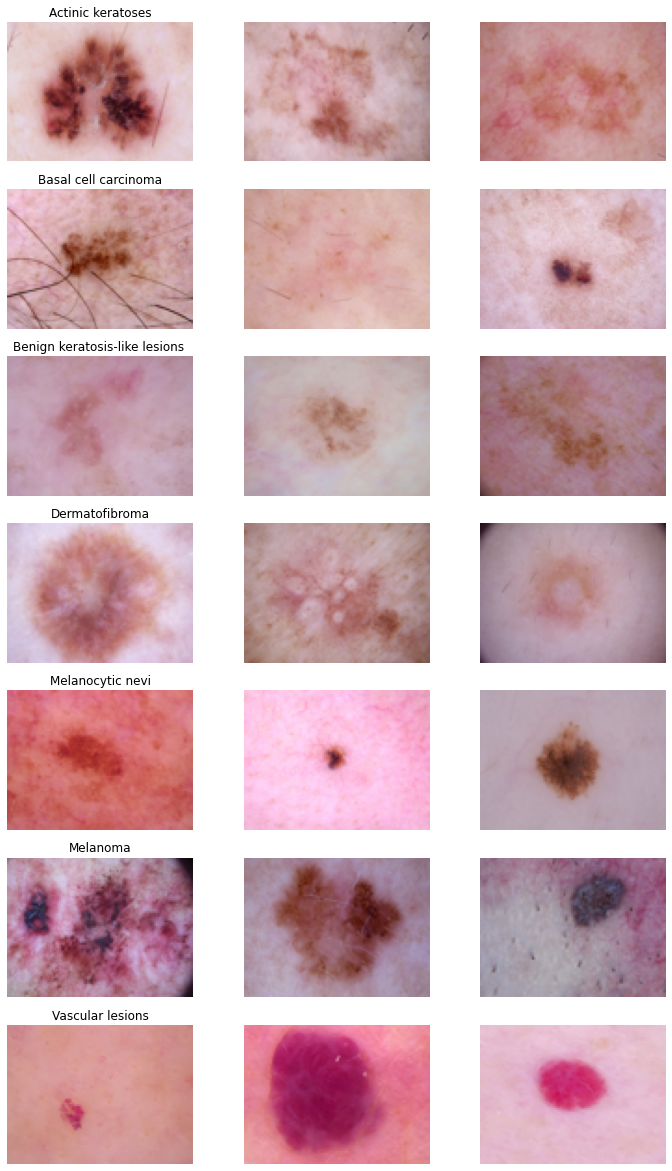

In [ ]:
img = skin_df.sample(n=500,replace=False, random_state=1)
img['image'] = img['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
#Image Sampling
n_samples = 3

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))

for n_axs, (type_name, type_rows) in zip(m_axs,img.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

The CSV file contains originally seven features. In the code lines above we add a few columns to support the data analysis and facilitate the extraction of images later on. The null entries are only related to the Age feature, as such no major data cleanse is required as the dataset is pretty much ready to use.

In [ ]:
basic_EDA(skin_df)

Number of Samples: 10015,
Number of Features: 10,
Duplicated Entries: 0,
Null Entries: 57,
Number of Rows with Null Entries: 57 0.6%


In [ ]:
summary_table(skin_df)

,Name,dtypes,Missing,Uniques
0,lesion_id,object,0,7470
1,image_id,object,0,10015
2,dx,object,0,7
3,dx_type,object,0,4
4,age,float64,57,18
5,sex,object,0,3
6,localization,object,0,15
7,path,object,0,10015
8,cell_type,object,0,7
9,cell_type_idx,int8,0,7


The summary helps to understand the type of metadata collected. We noticed that for some lesions there must be more than one image as the lesion and image ID do not match. The Uniques columns also indicate the number of classes (dx = 7), and how the age, sex and localization features were organized.

All the features are pretty much self-explanatory. To clarify, the **dx_type** column is the technique used to identify the type of skin lesion.

The count plots below help to understand the distribution of the data.

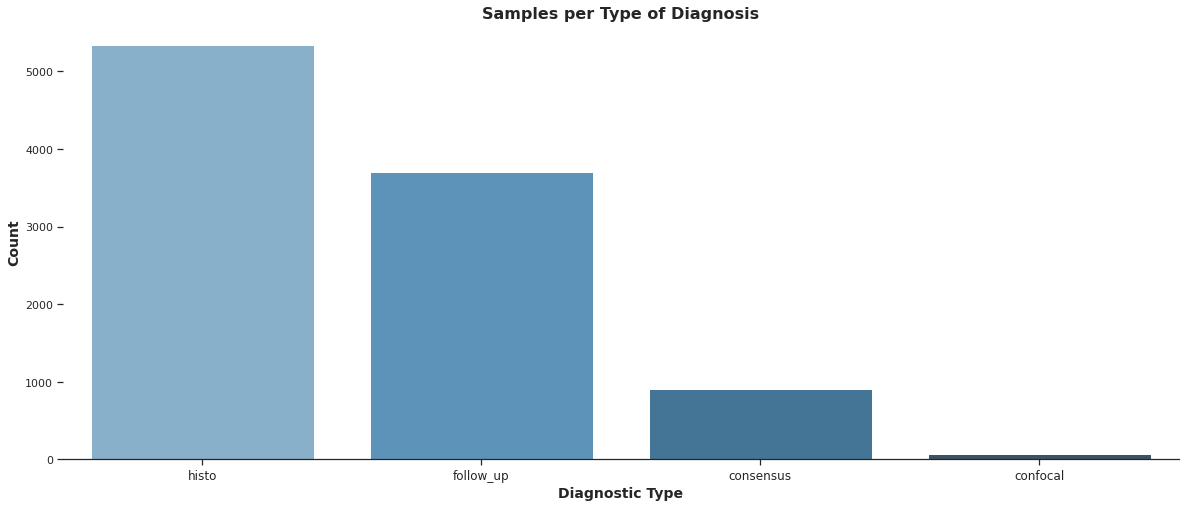

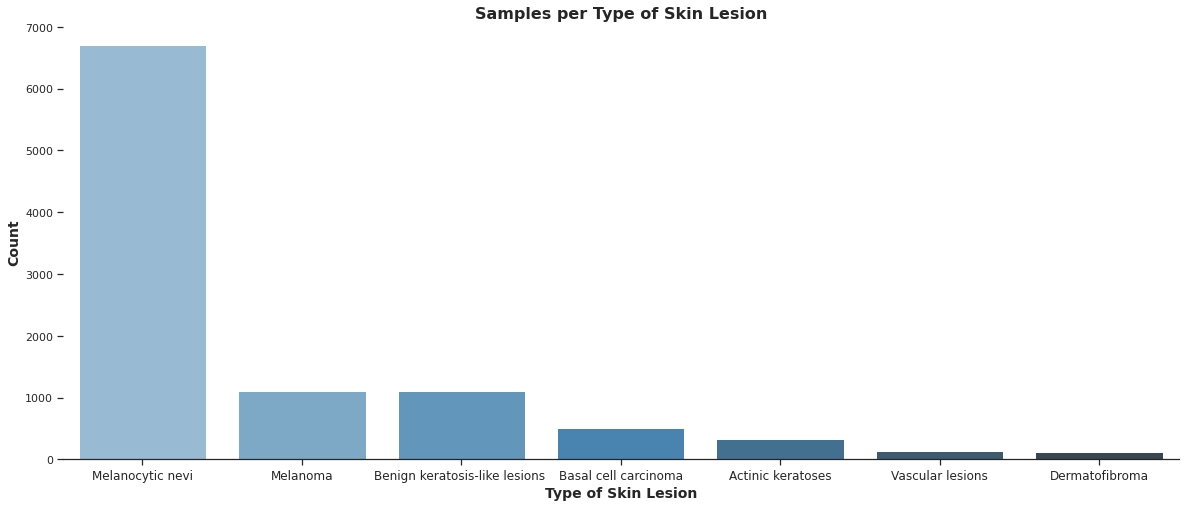

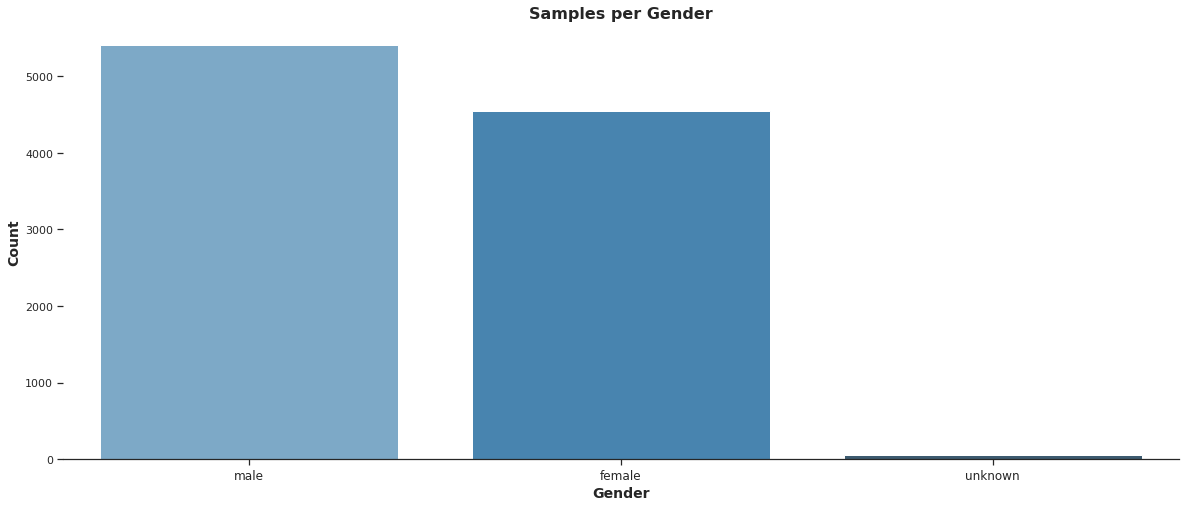

In [ ]:
countplot(skin_df,'dx_type', 'Diagnostic Type', 'Count', 'Samples per Type of Diagnosis')
countplot(skin_df,'cell_type', 'Type of Skin Lesion', 'Count', 'Samples per Type of Skin Lesion')
countplot(skin_df,'sex', 'Gender', 'Count', 'Samples per Gender')

* The main thing to keep in mind is the unbalance between the different classes of skin lesion. Approximately 67% of data accounts for Melanocytic Nevi samples
* The least represented classes are Dermatofibroma lesions and Vascular skin lesions, with only 115 and 142 samples, respectively
* The samples are mostly Male participants, approximately 55%, not a significant difference between Genders

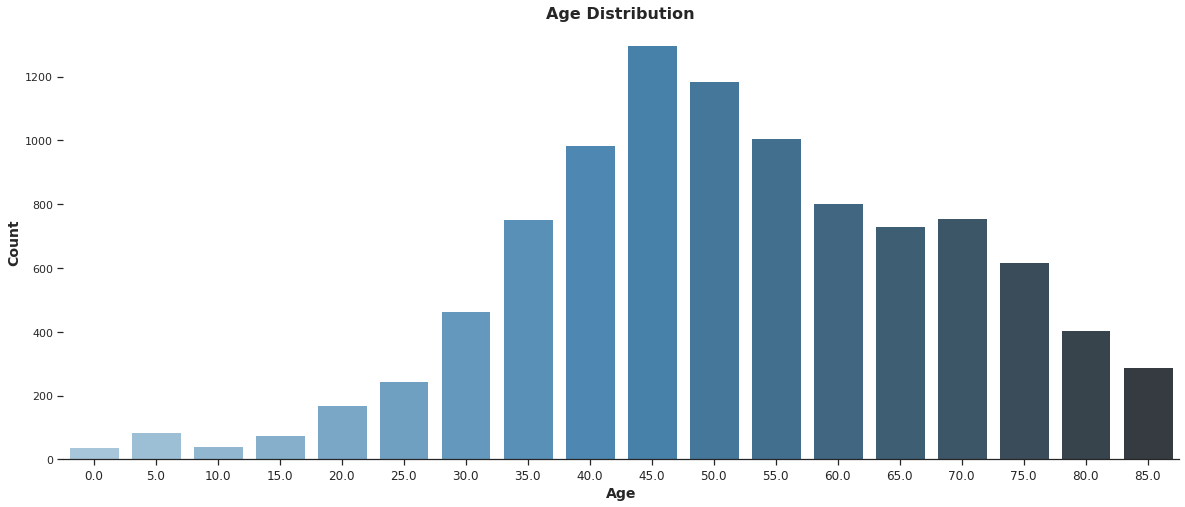

In [ ]:
skin_df['age'].fillna((skin_df['age'].mode()), inplace=True)

plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = skin_df,x='age',palette="Blues_d")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Age',fontsize = 14,weight = 'bold')
ax.set_ylabel('Count',fontsize = 14,weight = 'bold')
plt.title('Age Distribution', fontsize = 16,weight = 'bold');

* The samples are predominantly from patients within 40 - 55 years old
* The number of samples rises sharply after 25 years old, doubling the samples for 30 years old and almost doubling again for 35 years old
* Between the ages of 60 - 70 years old the number of samples remain almost stable, returning to the downward trend after 75 years old

## 2.1. Melanoma


The only malignant type of skin lesion present on this dataset is Malignant Melanoma, where surgical removal in the early stage of cancer can provide a cure. The remaining skin lesions are benign even though they may require treatment.

In this segment, we make a quick analysis of Melanoma skin lesions.

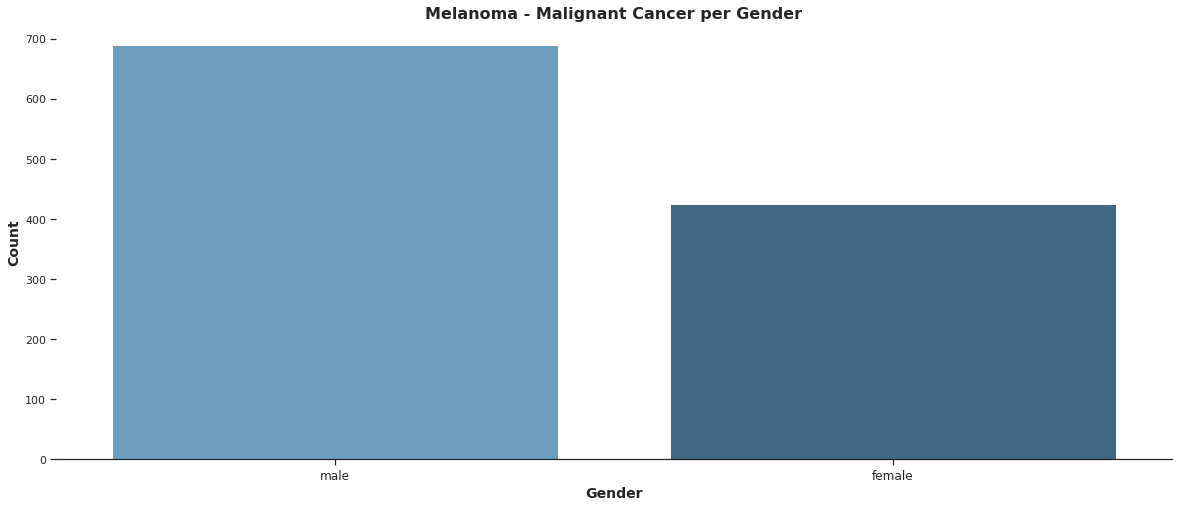

In [ ]:
skin_mel = skin_df.loc[:,['age','sex','localization','cell_type']]
skin_mel = skin_mel[skin_mel['cell_type'] == 'Melanoma']

countplot(skin_mel,'sex', 'Gender', 'Count', 'Melanoma - Malignant Cancer per Gender')

* Regarding gender, in the previous section, we saw a similar distribution across the main two genders. However, considering only Melanoma we can see from the above plot that more than 60% of the cases reported are Male

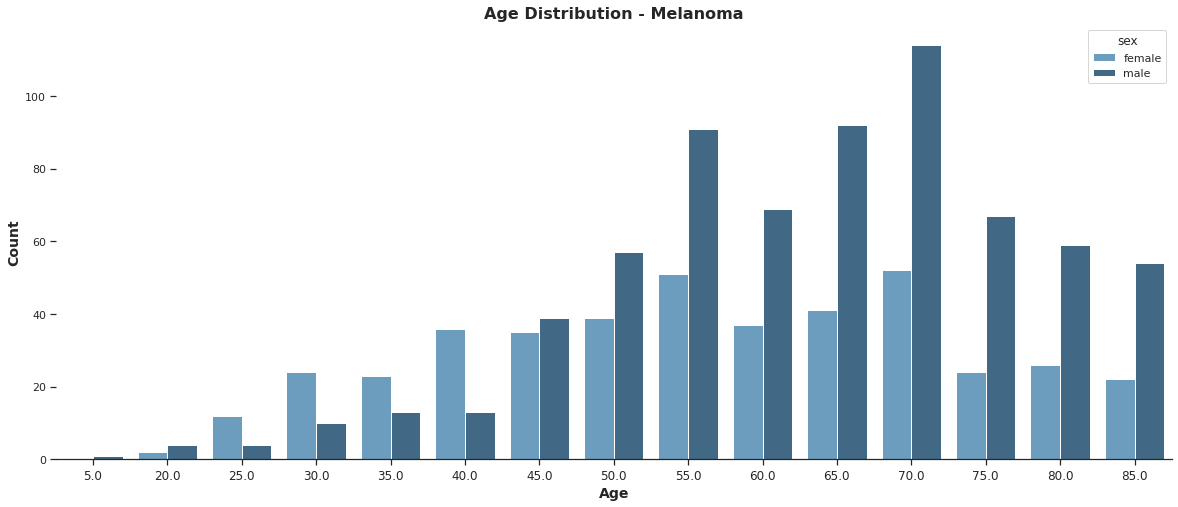

In [ ]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = skin_mel,x='age',palette="Blues_d", hue = 'sex')
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Age',fontsize = 14,weight = 'bold')
ax.set_ylabel('Count',fontsize = 14,weight = 'bold')
plt.title('Age Distribution - Melanoma', fontsize = 16,weight = 'bold');

* The age distribution is quite different for Melanoma diagnostics when compared to the whole dataset
* For both genders, there are two distinct peaks, at 55 and 70 years old. The peaks could be related to the period people usually do a full health check-up
* Younger Melanoma samples are more likely to be females. Impressive difference of gender for the ages between 25 - 40 years old
* For males, melanoma has a higher incidence in older patients
* After 40 years of age, the number of cases regarding female samples seems to stabilize. The peaks at 55 and 70 years old are not as expressive as the male samples

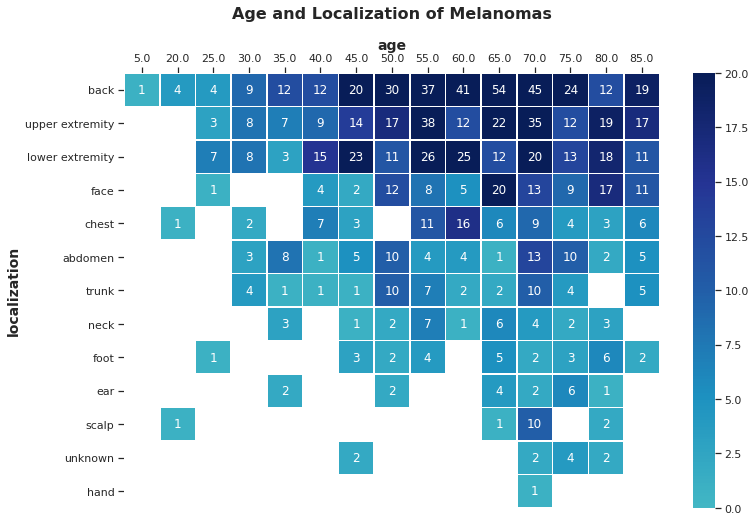

In [ ]:
skin_local = skin_mel.groupby(['localization']).size().sort_values(ascending=False, inplace=False).reset_index()
skin_local.columns = ['localization', 'count']
sort_by = skin_local['localization']

skin_heat = skin_mel.groupby(['age','localization']).size().reset_index()
skin_heat.columns = ['age', 'localization', 'count']
skin_heat.sort_values('count', ascending=False, inplace=True)

def heatmap(df, index,columns,values,vmax,sort_by,Title):
    df_wide = df.pivot(index=index, columns=columns, values=values)
    df_wide = df_wide.reindex(index=sort_by)
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(df_wide, annot=True, fmt='.0f', yticklabels='auto', cmap=sns.color_palette("YlGnBu", as_cmap=True), center=.2,vmin = 0, vmax = vmax,linewidths=.5)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(columns,fontsize = 14,weight = 'bold')
    ax.set_ylabel(index,fontsize = 14,weight = 'bold')
    ax.set_title(Title,fontsize = 16,weight = 'bold',pad=20)
    plt.show()

heatmap(skin_heat,'localization', 'age','count', 20,sort_by,'Age and Localization of Melanomas')

* The heatmap makes a good representation of how age influences Cancer incidence. Note the cluster between the ages of 45 to 70
* Back, upper and lower extremities are the most common locations of this melanoma. For the age group of 50 and 70 years old, the face, abdomen, chest and trunk also present a higher number of incidence.
* The scalp seems to be a more common localization only for 70 years old.
* The localizations do not seem to be related to the parts of the body most commonly exposed to the sun. If it was the case, scalp, hands and face should have a higher incidence